# <span style="font-family:cursive;text-align:center">⬇️ Import Libraries</span>

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import spacy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from xgboost import XGBRegressor
from category_encoders import TargetEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential, load_model
from keras.layers import Embedding, LSTM, Dense
from concurrent.futures import ProcessPoolExecutor

# <span style="font-family:cursive;text-align:center">⬇️ Import Data</span>

In [2]:
# Load dataset

df = pd.read_csv('/kaggle/input/beers/beer_train.csv')
df.head(5)

,index,beer/ABV,beer/beerId,beer/brewerId,beer/name,beer/style,review/appearance,review/aroma,review/overall,review/palate,review/taste,review/text,review/timeStruct,review/timeUnix,user/ageInSeconds,user/birthdayRaw,user/birthdayUnix,user/gender,user/profileName
0,40163,5.0,46634,14338,Chiostro,Herbed / Spiced Beer,4.0,4.0,4.0,4.0,4.0,Pours a clouded gold with a thin white head. N...,"{'min': 38, 'hour': 3, 'mday': 16, 'sec': 10, ...",1229398690,NaN,NaN,NaN,NaN,RblWthACoz
1,8135,11.0,3003,395,Bearded Pat's Barleywine,American Barleywine,4.0,3.5,3.5,3.5,3.0,12oz bottle into 8oz snifter.\t\tDeep ruby red...,"{'min': 38, 'hour': 23, 'mday': 8, 'sec': 58, ...",1218238738,NaN,NaN,NaN,NaN,BeerSox
2,10529,4.7,961,365,Naughty Nellie's Ale,American Pale Ale (APA),3.5,4.0,3.5,3.5,3.5,First enjoyed at the brewpub about 2 years ago...,"{'min': 7, 'hour': 18, 'mday': 26, 'sec': 2, '...",1101492422,NaN,NaN,NaN,Male,mschofield
3,44610,4.4,429,1,Pilsner Urquell,Czech Pilsener,3.0,3.0,2.5,3.0,3.0,First thing I noticed after pouring from green...,"{'min': 7, 'hour': 1, 'mday': 20, 'sec': 5, 'y...",1308532025,1.209827e+09,"Aug 10, 1976",208508400.0,Male,molegar76
4,37062,4.4,4904,1417,Black Sheep Ale (Special),English Pale Ale,4.0,3.0,3.0,3.5,2.5,A: pours an amber with a one finger head but o...,"{'min': 51, 'hour': 6, 'mday': 12, 'sec': 48, ...",1299912708,NaN,NaN,NaN,NaN,Brewbro000


# <span style="font-family:cursive;text-align:center">📊 Exploratory Data Analysis</span>

In [3]:
df.shape

(37500, 19)

In [4]:
df.columns

Index(['index', 'beer/ABV', 'beer/beerId', 'beer/brewerId', 'beer/name',
       'beer/style', 'review/appearance', 'review/aroma', 'review/overall',
       'review/palate', 'review/taste', 'review/text', 'review/timeStruct',
       'review/timeUnix', 'user/ageInSeconds', 'user/birthdayRaw',
       'user/birthdayUnix', 'user/gender', 'user/profileName'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37500 entries, 0 to 37499
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              37500 non-null  int64  
 1   beer/ABV           37500 non-null  float64
 2   beer/beerId        37500 non-null  int64  
 3   beer/brewerId      37500 non-null  int64  
 4   beer/name          37500 non-null  object 
 5   beer/style         37500 non-null  object 
 6   review/appearance  37500 non-null  float64
 7   review/aroma       37500 non-null  float64
 8   review/overall     37500 non-null  float64
 9   review/palate      37500 non-null  float64
 10  review/taste       37500 non-null  float64
 11  review/text        37490 non-null  object 
 12  review/timeStruct  37500 non-null  object 
 13  review/timeUnix    37500 non-null  int64  
 14  user/ageInSeconds  7856 non-null   float64
 15  user/birthdayRaw   7856 non-null   object 
 16  user/birthdayUnix  785

In [6]:
df.describe()

,index,beer/ABV,beer/beerId,beer/brewerId,review/appearance,review/aroma,review/overall,review/palate,review/taste,review/timeUnix,user/ageInSeconds,user/birthdayUnix
count,37500.000000,37500.000000,37500.000000,37500.000000,37500.000000,37500.000000,37500.00000,37500.000000,37500.000000,3.750000e+04,7.856000e+03,7.856000e+03
mean,24951.887573,7.403725,21861.152027,3036.595120,3.900053,3.873240,3.88944,3.854867,3.922440,1.232794e+09,1.176705e+09,2.416303e+08
std,14434.009669,2.318145,18923.130832,5123.084675,0.588778,0.680865,0.70045,0.668068,0.716504,7.190955e+07,3.375514e+08,3.375514e+08
min,0.000000,0.100000,175.000000,1.000000,0.000000,1.000000,0.00000,1.000000,1.000000,9.262944e+08,7.034366e+08,-2.208960e+09
25%,12422.500000,5.400000,5441.000000,395.000000,3.500000,3.500000,3.50000,3.500000,3.500000,1.189194e+09,9.794810e+08,1.433628e+08
50%,24942.500000,6.900000,17538.000000,1199.000000,4.000000,4.000000,4.00000,4.000000,4.000000,1.248150e+09,1.100009e+09,3.183264e+08
75%,37416.750000,9.400000,34146.000000,1315.000000,4.500000,4.500000,4.50000,4.500000,4.500000,1.291330e+09,1.274973e+09,4.388544e+08
max,49999.000000,57.700000,77207.000000,27797.000000,5.000000,5.000000,5.00000,5.000000,5.000000,1.326267e+09,3.627295e+09,7.148988e+08


In [7]:
df.describe(include=['O']).T # to include categorical columns

,count,unique,top,freq
beer/name,37500,1688,Founders Breakfast Stout,1883
beer/style,37500,95,American Double / Imperial Stout,4495
review/text,37490,37482,"The beer has a bit of a reddish color to it, w...",2
review/timeStruct,37500,37490,"{'min': 0, 'hour': 0, 'mday': 10, 'sec': 1, 'y...",3
user/birthdayRaw,7856,1432,"Sep 14, 1980",76
user/gender,15314,2,Male,15069
user/profileName,37495,7441,northyorksammy,141


In [8]:
df.nunique()

index                37500
beer/ABV               126
beer/beerId           1731
beer/brewerId          212
beer/name             1688
beer/style              95
review/appearance       10
review/aroma             9
review/overall          10
review/palate            9
review/taste             9
review/text          37482
review/timeStruct    37490
review/timeUnix      37490
user/ageInSeconds     1471
user/birthdayRaw      1432
user/birthdayUnix     1432
user/gender              2
user/profileName      7441
dtype: int64

In [9]:
# Viewing unique values on each column

for i in df.columns:
    print(f'unique values in {i}:')
    print(df[i].unique(),'\n')

unique values in index:
[40163  8135 10529 ... 47720 33233 23758] 

unique values in beer/ABV:
[ 5.   11.    4.7   4.4  10.   12.6   8.4   9.    6.2   8.5  10.5  11.2
  7.    8.3   6.5   9.2   7.2   6.    5.5  12.    6.1   4.75  5.1   8.6
  6.6   6.9   4.2   6.8   5.4   7.75 10.2   9.4   4.8   7.7   9.5   7.82
  5.3   4.3   3.    8.   10.6   5.9   6.7   5.2   4.19  5.7   4.5   3.8
  4.6   3.5   4.    4.9   8.1   9.8   5.6   5.8   8.2   6.3   7.6   5.79
  7.5  14.   12.5  10.8   7.4  13.    6.4   7.1  10.4   9.1  11.1   5.59
 15.    3.75  5.25  5.11 11.3   7.3   3.6   8.9   8.8   2.4   9.7  10.9
  2.2   9.9   4.1   3.9   9.6   1.5  10.75 10.25 11.5   5.75  7.8   3.1
  4.55  2.5   7.9   4.25 11.9   3.7  39.44 16.   12.9  10.3   0.5   9.3
  2.8   8.7   5.47  6.25  4.37  8.25  0.1   3.2   7.26  7.25 14.5  43.
  8.85  6.32  3.4  12.8  57.7  30.86] 

unique values in beer/beerId:
[46634  3003   961 ... 49959 71810 29697] 

unique values in beer/brewerId:
[14338   395   365     1  1417    14 

In [10]:
df.isna().sum()

index                    0
beer/ABV                 0
beer/beerId              0
beer/brewerId            0
beer/name                0
beer/style               0
review/appearance        0
review/aroma             0
review/overall           0
review/palate            0
review/taste             0
review/text             10
review/timeStruct        0
review/timeUnix          0
user/ageInSeconds    29644
user/birthdayRaw     29644
user/birthdayUnix    29644
user/gender          22186
user/profileName         5
dtype: int64

In [11]:
df.duplicated().sum()

0

In [12]:
df.shape

(37500, 19)

In [13]:
df.isna().sum()

index                    0
beer/ABV                 0
beer/beerId              0
beer/brewerId            0
beer/name                0
beer/style               0
review/appearance        0
review/aroma             0
review/overall           0
review/palate            0
review/taste             0
review/text             10
review/timeStruct        0
review/timeUnix          0
user/ageInSeconds    29644
user/birthdayRaw     29644
user/birthdayUnix    29644
user/gender          22186
user/profileName         5
dtype: int64

# <span style="font-family:cursive;text-align:center">Feature Engineering and Encoding</span>

In [14]:
df.nunique()

index                37500
beer/ABV               126
beer/beerId           1731
beer/brewerId          212
beer/name             1688
beer/style              95
review/appearance       10
review/aroma             9
review/overall          10
review/palate            9
review/taste             9
review/text          37482
review/timeStruct    37490
review/timeUnix      37490
user/ageInSeconds     1471
user/birthdayRaw      1432
user/birthdayUnix     1432
user/gender              2
user/profileName      7441
dtype: int64

In [15]:
df['review/text'] = df['review/text'].fillna('')

In [16]:
# Convert beer style to numerical values
encoder = LabelEncoder()
df['beer/style'] = encoder.fit_transform(df['beer/style'])

# Extract year from review time
df['review/year'] = pd.to_datetime(df['review/timeUnix'], unit='s').dt.year

# Calculate the length of each review
df['review/length'] = df['review/text'].apply(len)

# Target encode 'beer/name'
encoder = TargetEncoder()
df['beer/name'] = encoder.fit_transform(df['beer/name'], df['review/overall'])

# Drop unnecessary columns
df = df.drop(columns=['index', 'beer/beerId', 'beer/brewerId', 'user/birthdayRaw', 'user/birthdayUnix', 'user/profileName', 'user/gender', 'review/text', 'review/timeStruct'])

In [17]:
df

,beer/ABV,beer/name,beer/style,review/appearance,review/aroma,review/overall,review/palate,review/taste,review/timeUnix,user/ageInSeconds,review/year,review/length
0,5.00,3.798809,61,4.0,4.0,4.0,4.0,4.0,1229398690,NaN,2008,519
1,11.00,3.667611,4,4.0,3.5,3.5,3.5,3.0,1218238738,NaN,2008,568
2,4.70,3.635385,14,3.5,4.0,3.5,3.5,3.5,1101492422,NaN,2004,392
3,4.40,3.834741,35,3.0,3.0,2.5,3.0,3.0,1308532025,1.209827e+09,2011,391
4,4.40,3.871032,46,4.0,3.0,3.0,3.5,2.5,1299912708,NaN,2011,486
...,...,...,...,...,...,...,...,...,...,...,...,...
37495,5.50,3.219836,58,4.0,3.5,3.5,3.5,3.5,1207871761,NaN,2008,616
37496,8.50,3.930315,85,4.5,4.0,3.5,4.5,4.5,1263102314,NaN,2010,894
37497,4.75,3.814056,75,4.0,3.5,4.0,4.5,4.0,1067043816,NaN,2003,539
37498,11.20,4.388619,11,4.0,4.0,4.0,5.0,5.0,1296330753,NaN,2011,683


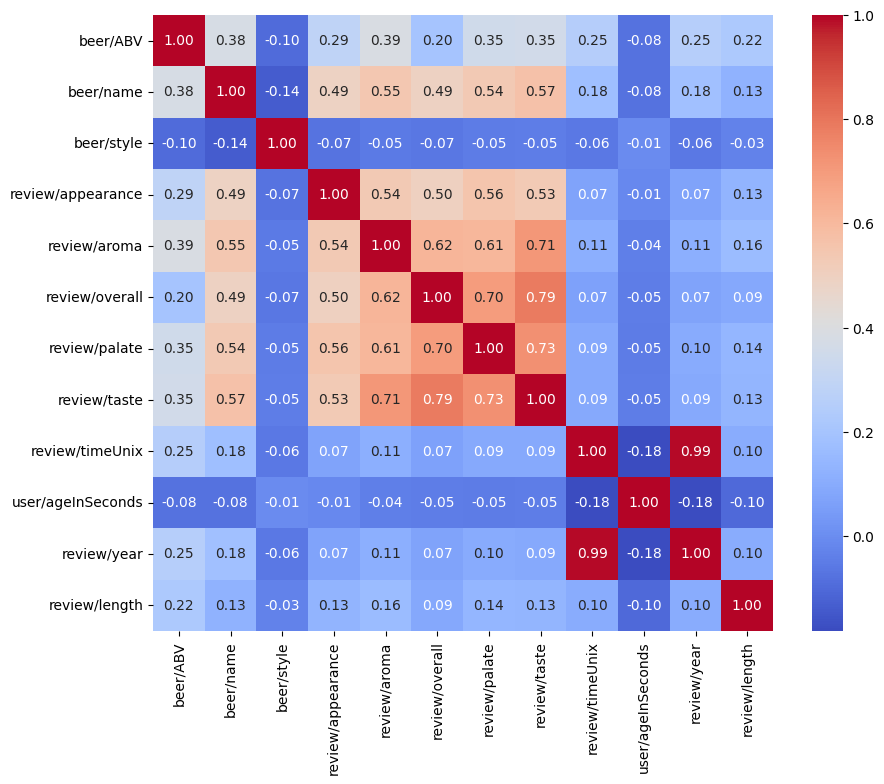

In [18]:
# Calculate and plot a heat of the correlation matrix
corr = df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

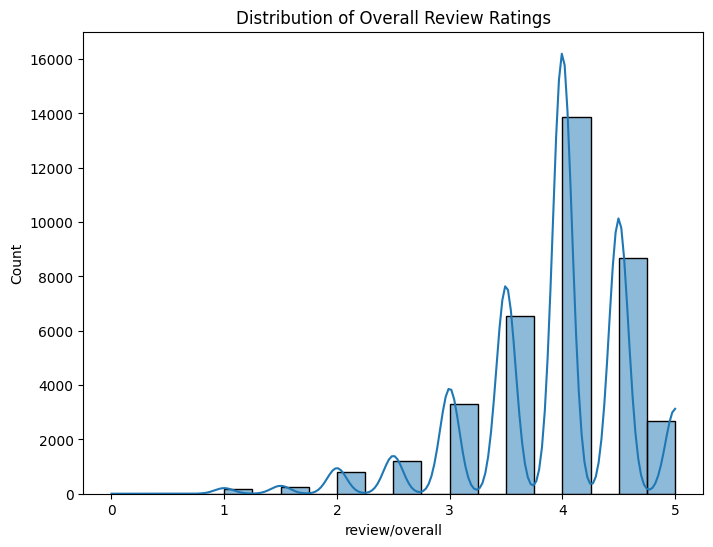

In [19]:
# Plot a histogram of the target variable ('review/overall')
plt.figure(figsize=(8,6))
sns.histplot(df['review/overall'], bins=20, kde=True)
plt.title('Distribution of Overall Review Ratings')
plt.show()

# Feature Selection & Training

In [20]:
# Split the data into training and test sets 
X = df.drop(columns = ['review/overall', 'review/timeUnix', 'review/year', 'review/length', 'user/ageInSeconds'], axis=1)
y = df['review/overall']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
X

,beer/ABV,beer/name,beer/style,review/appearance,review/aroma,review/palate,review/taste
0,5.00,3.798809,61,4.0,4.0,4.0,4.0
1,11.00,3.667611,4,4.0,3.5,3.5,3.0
2,4.70,3.635385,14,3.5,4.0,3.5,3.5
3,4.40,3.834741,35,3.0,3.0,3.0,3.0
4,4.40,3.871032,46,4.0,3.0,3.5,2.5
...,...,...,...,...,...,...,...
37495,5.50,3.219836,58,4.0,3.5,3.5,3.5
37496,8.50,3.930315,85,4.5,4.0,4.5,4.5
37497,4.75,3.814056,75,4.0,3.5,4.5,4.0
37498,11.20,4.388619,11,4.0,4.0,5.0,5.0


# <span style="font-family:cursive;text-align:center">🧰 Model-1 (Random Forest)</span>

In [22]:
%%time
# Train a RandomForestRegressor
model = RandomForestRegressor(random_state=1, criterion='squared_error', max_depth = 15, min_samples_split= 2)
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

CPU times: user 5.41 s, sys: 51.5 ms, total: 5.46 s
Wall time: 5.47 s


In [23]:
# Evaluating the model
print(" Training data scores\n","--"*10)
print(" RMSE:", np.sqrt(mean_squared_error(y_test,y_pred)))
print(" MAE:", mean_absolute_error(y_test,y_pred))
print(" MSE:", mean_squared_error(y_test,y_pred))
print(" R2:", r2_score(y_test,y_pred))

 Training data scores
 --------------------
 RMSE: 0.41019893641890554
 MAE: 0.31252973323000965
 MSE: 0.1682631674392013
 R2: 0.6579443924751018


/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 9.444444444444438, 'iteration')

<Figure size 700x500 with 0 Axes>

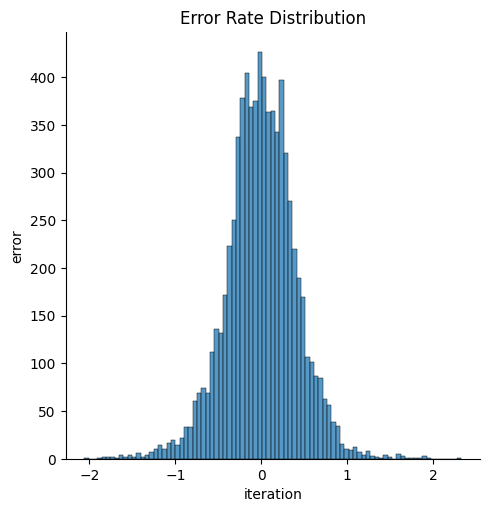

In [24]:
plt.figure(figsize = (7,5))
sns.displot(y_test - y_pred)
plt.title("Error Rate Distribution");
plt.ylabel("error")
plt.xlabel("iteration")

# Hyperparameter Tuning

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2,5,10]
}

# Initialize the model
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit GridSearchCV
grid_search.fit(X, y)

# Get the best parameters
best_params = grid_search.best_params_
print(f'Best parameters: {best_params}')

Best parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}


# Training best params and Evalution

In [26]:
# Retrain the model with the best parameters
best_model = RandomForestRegressor(n_estimators=best_params['n_estimators'],
                                  max_depth=best_params['max_depth'],
                                  min_samples_split=best_params['min_samples_split'], random_state=42)
best_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = best_model.predict(X_test)

# Calculate RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE: {rmse}')

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print(f'MAE: {mae}')

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print(f'Rsquared: {r2}')

mse = mean_squared_error(y_test,y_pred)
print(f'MSE: {mse}')

RMSE: 0.39755782269558615
MAE: 0.3028582243110388
Rsquared: 0.678701823032104
MSE: 0.1580522223864551


/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 9.444444444444438, 'frequency')

<Figure size 700x500 with 0 Axes>

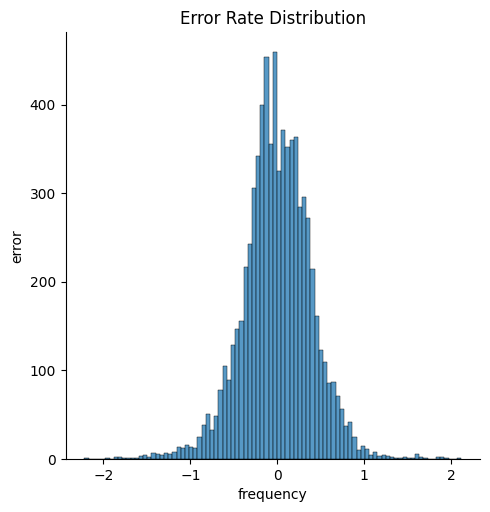

In [27]:
plt.figure(figsize = (7,5))
sns.displot(y_test - y_pred)
plt.title("Error Rate Distribution");
plt.ylabel("error")
plt.xlabel("frequency")

# Model-2 (Lasso Regression)

In [28]:
df = pd.read_csv('/kaggle/input/beers/beer_train.csv')

In [29]:
df['review/text'] = df['review/text'].fillna('')

In [30]:
# Convert beer style to numerical values
encoder = LabelEncoder()
df['beer/style'] = encoder.fit_transform(df['beer/style'])

# Extract year from review time
df['review/year'] = pd.to_datetime(df['review/timeUnix'], unit='s').dt.year

# Calculate the length of each review
df['review/length'] = df['review/text'].apply(len)

# Target encode 'beer/name'
encoder = TargetEncoder()
df['beer/name'] = encoder.fit_transform(df['beer/name'], df['review/overall'])

# Drop unnecessary columns
df = df.drop(columns=['index', 'beer/beerId', 'beer/brewerId', 'user/birthdayRaw', 'user/birthdayUnix', 'user/profileName', 'user/gender', 'review/text', 'review/timeStruct'])

In [31]:
# Split the data into training and test sets 
X = df.drop(columns = ['review/overall', 'review/timeUnix', 'review/year', 'review/length', 'user/ageInSeconds'], axis=1)
y = df['review/overall']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
lasso = Lasso()
lasso.fit(X_train, y_train)
y_pred_ = lasso.predict(X_test)

In [33]:
print(" Training data scores\n","--"*10)
print(" RMSE:", np.sqrt(mean_squared_error(y_test,y_pred_)))
print(" MAE:", mean_absolute_error(y_test,y_pred_))
print(" MSE:", mean_squared_error(y_test,y_pred_))
print(" R2:", r2_score(y_test,y_pred_))

 Training data scores
 --------------------
 RMSE: 0.7008173931072689
 MAE: 0.5241039389361674
 MSE: 0.4911450184816682
 R2: 0.0015705145912126017


/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 9.444444444444438, 'frequency')

<Figure size 700x500 with 0 Axes>

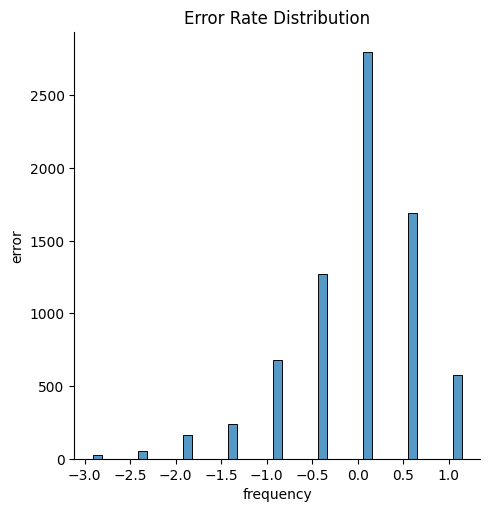

In [34]:
plt.figure(figsize = (7,5))
sns.displot(y_test - y_pred_)
plt.title("Error Rate Distribution");
plt.ylabel("error")
plt.xlabel("frequency")

# Model-3 (Using LSTM for predicting the Overall Rating)

In [35]:
df = pd.read_csv('/kaggle/input/beers/beer_train.csv')

In [36]:
def missing_values_table(df):
    # Total missing values by column
    mis_val = df.isnull().sum()

    # Percentage of missing values by column
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # build a table with the thw columns
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)

    # Print some summary information
    print("Your selected dataframe has " + str(df.shape[1]) + "columns.\n"
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [37]:
print("Columns with null values: ")
print(list(df.columns[df.isnull().any()]))
print('===========================================')
# Missing values for training data
missing_values = missing_values_table(df)
missing_values[:20].style.background_gradient(cmap='Blues')

Columns with null values: 
['review/text', 'user/ageInSeconds', 'user/birthdayRaw', 'user/birthdayUnix', 'user/gender', 'user/profileName']
Your selected dataframe has 19columns.
There are 6 columns that have missing values.


,Missing Values,% of Total Values
user/ageInSeconds,29644,79.100000
user/birthdayRaw,29644,79.100000
user/birthdayUnix,29644,79.100000
user/gender,22186,59.200000
review/text,10,0.000000
user/profileName,5,0.000000


In [38]:
df.nunique()

index                37500
beer/ABV               126
beer/beerId           1731
beer/brewerId          212
beer/name             1688
beer/style              95
review/appearance       10
review/aroma             9
review/overall          10
review/palate            9
review/taste             9
review/text          37482
review/timeStruct    37490
review/timeUnix      37490
user/ageInSeconds     1471
user/birthdayRaw      1432
user/birthdayUnix     1432
user/gender              2
user/profileName      7441
dtype: int64

In [39]:
df.drop(columns = ['index', 'user/ageInSeconds', 'user/birthdayRaw', 'user/birthdayUnix', 'user/gender', 'user/profileName', 'review/timeStruct', 'review/timeUnix'], axis = 1, inplace=True)

In [40]:
df.isna().sum()

beer/ABV              0
beer/beerId           0
beer/brewerId         0
beer/name             0
beer/style            0
review/appearance     0
review/aroma          0
review/overall        0
review/palate         0
review/taste          0
review/text          10
dtype: int64

In [41]:
df.dropna(axis=0, how="any").shape

(37490, 11)

In [42]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Load spaCy language model
nlp = spacy.load("en_core_web_sm")

# Define the text preprocessing function
def preprocess(text):
    if isinstance(text, str):  # Check if the text is a non-null string
        # Convert text to lowercase
        text = text.lower()
        # Remove punctuation and numbers
        text = ''.join([c for c in text if c.isalpha() or c.isspace()])
        # Tokenize the text using NLTK
        tokens = nltk.word_tokenize(text)
        # Remove stopwords using NLTK
        stopwords = set(nltk.corpus.stopwords.words('english'))
        tokens = [t for t in tokens if t not in stopwords]
        # Lemmatize the tokens using spaCy
        tokens = [nlp(t)[0].lemma_ for t in tokens]
        # Join the tokens back to a text
        text = ' '.join(tokens)
        # Return the preprocessed text
        return text
    else:
        return ''  # Return an empty string for NaN values

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [43]:
# Define a list of text feature columns to preprocess
text_feature_columns = ['beer/name', 'beer/style', 'review/text']

# Combine the preprocessed text features into a single text column
df['combined_text'] = df[text_feature_columns].apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)

# Load the tokenizer
with open('/kaggle/input/models/tokenizer.pickle', 'rb') as handle:
  tokenizer = pickle.load(handle)

# Convert text to sequences and pad sequences
sequences = tokenizer.texts_to_sequences(df['combined_text'])
data = pad_sequences(sequences)

In [44]:
X = data

# Prepare labels
y = df['review/overall']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
# Define the model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=100, input_length=X_train.shape[1]))
model.add(LSTM(100))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 522, 100)          500000    
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 580,501
Trainable params: 580,501
Non-trainable params: 0
_________________________________________________________________


In [46]:
model_exists = False

# If the model didn't exist train it
if not model_exists:
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=40)
    # Save the trained model
    model.save('/kaggle/working/model.h5')

else:
# Load the existing model
    model = load_model('/kaggle/working/model.h5')

Epoch 1/40
938/938 [==============================] - 512s 543ms/step - loss: 0.5474 - val_loss: 0.2982
Epoch 2/40
938/938 [==============================] - 511s 545ms/step - loss: 0.2709 - val_loss: 0.2760
Epoch 3/40
938/938 [==============================] - 513s 547ms/step - loss: 0.2304 - val_loss: 0.2750
Epoch 4/40
938/938 [==============================] - 512s 545ms/step - loss: 0.2023 - val_loss: 0.2822
Epoch 5/40
938/938 [==============================] - 508s 542ms/step - loss: 0.1844 - val_loss: 0.2796
Epoch 6/40
938/938 [==============================] - 509s 542ms/step - loss: 0.1699 - val_loss: 0.2851
Epoch 7/40
938/938 [==============================] - 509s 543ms/step - loss: 0.1557 - val_loss: 0.2947
Epoch 8/40
938/938 [==============================] - 447s 476ms/step - loss: 0.1430 - val_loss: 0.3116
Epoch 9/40
938/938 [==============================] - 432s 461ms/step - loss: 0.1327 - val_loss: 0.3208
Epoch 10/40
938/938 [==============================] - 432s 460m

In [47]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(30000, 522)
(7500, 522)
(30000,)
(7500,)


In [48]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the error of the predictions
print(" Training data scores\n","--"*10)
print(" RMSE:", np.sqrt(mean_squared_error(y_test,y_pred)))
print(" MAE:", mean_absolute_error(y_test,y_pred))
print(" MSE:", mean_squared_error(y_test,y_pred))
print(" R2:", r2_score(y_test,y_pred))

235/235 [==============================] - 29s 122ms/step
 Training data scores
 --------------------
 RMSE: 0.6455955606082737
 MAE: 0.49502739505767823
 MSE: 0.41679362787711116
 R2: 0.15271654655184497


# Model Evaluation

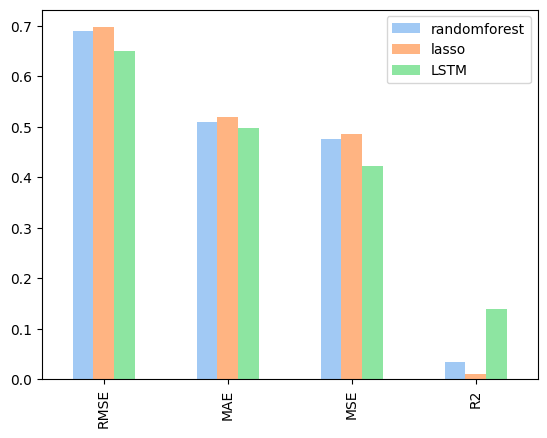

In [49]:
error_rec = {
    "randomforest": {
          'RMSE': 0.6892106634681464,
          'MAE': 0.5103883428069858,
          'MSE': 0.4750113386382026,
          'R2': 0.03436804089751411,
    },
    "lasso": {
          'RMSE': 0.6975111592936514,
          'MAE': 0.520149044781461,
          'MSE': 0.4865218173391735,
          'R2': 0.010968839248789441,
    },
    "LSTM": {
          'RMSE': 0.6506458109695253,
          'MAE': 0.4982813061952591,
          'MSE': 0.42333997133219126,
          'R2': 0.13940874115585322,
    }
}
pd.DataFrame(error_rec).plot(kind="bar", 
             color=[
                 sns.color_palette("pastel")[0], 
                 sns.color_palette("pastel")[1], 
                 sns.color_palette("pastel")[2]]);